In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd 'drive/My Drive/Development/Biometrics/fingerprint'

/content/drive/My Drive/Development/Biometrics/fingerprint


# Fingerprint Recognition

In [3]:
import cv2 # OpenCV
import numpy as np # Array processing
import matplotlib.pyplot as plt # Plotting
%matplotlib inline
from pathlib import Path # File path processing
import fprmodules.enhancement as fe # Fingerprint enhancement
from sklearn.metrics import roc_curve
import pickle # Save and read intermediate results
from tqdm.notebook import tqdm as tqdm_notebook # Visual progress bar
from IPython.display import clear_output
try:
  import pyeer
except ImportError as e:
  !pip install pyeer
  import pyeer # Simple biometric metrics
  # Install opencv-contrib if SIFT/SURF is being used.
  !pip uninstall opencv-python
  !pip uninstall opencv-contrib-python
  !pip install opencv-python==3.4.2.16
  !pip install opencv-contrib-python==3.4.2.16
  clear_output()
import seaborn as sns
sns.set(style="dark")
from IPython.core.display import HTML
def center_plots(horizontal=False):
  display(HTML("""
  <style>
  #output-body {
    display: flex;
    flex-direction: """ + ('row' if horizontal else 'column') + """;
    align-items: center;
    justify-content: center;
  }
  </style>
  """))
import os.path

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Reading image data and conversion to gray scale

In [0]:
def read_database(path):
    """
    Read a whole database, stored in a single folder with filenames as 
      XXY.tif with XX the individual number and Y the fingerprint number 
      for this individual returns a list of images and a list of associated 
      identity labels.
    """
    images = []
    labels = []
    imagePaths = sorted(Path(path).rglob("*.tif"))
    for imagePath in tqdm_notebook(imagePaths):
        image = cv2.imread(path + imagePath.name)
        if (len(image.shape) > 2):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        rows,cols = np.shape(image);
        aspect_ratio = np.double(rows) / np.double(cols);
        new_rows = 350; # randomly selected number
        new_cols = new_rows / aspect_ratio;
        image = cv2.resize(image, (np.int(new_cols), np.int(new_rows)));
        images.append(image)
        label = imagePath.stem[1:3]
        labels.append(label)
    return (images, labels)


(350, 363)


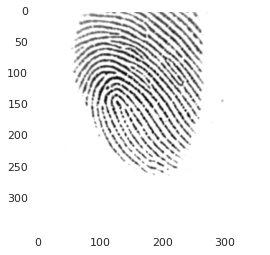

In [5]:
# Load dataset
selected_database = 1 # select database here
images, labels = read_database('./fprdata/FVC2002/DB' + str(selected_database) + '_B/')

# Verify through visualisation
print(images[0].shape)
plt.imshow(images[1],cmap='gray')
plt.show()

### Preprocessing: enhancement using ridge orientation/frequency estimation and segmentation of foreground

*There was some bug with the aspect ratio being set wrong which led to poor segmentation or enhancement in some cases. I fixed this, also replaced the first image in the first database as it seemed to be some processed version of the original.*

In [0]:
def enhance_images(images):
    """
    Enhance the given images and determine their segmentation masks.
    """
    images_e_u = []
    orientations = []
    frequencies = []
    masks = []
    for i, image in enumerate(tqdm_notebook(images)):
        try:
            img_e, mask, orientim, freqim = fe.image_enhance(image) # Gabor filtering
            img_e_u = cv2.normalize(img_e, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=0) # normalize in [0,255] range
            images_e_u.append(img_e_u)
        except:
            print('An error occured for image: ', i)
            images_e_u.append(image)
        masks.append(mask)
        orientations.append(orientim)
        frequencies.append(freqim)
    return images_e_u, orientations, frequencies, masks

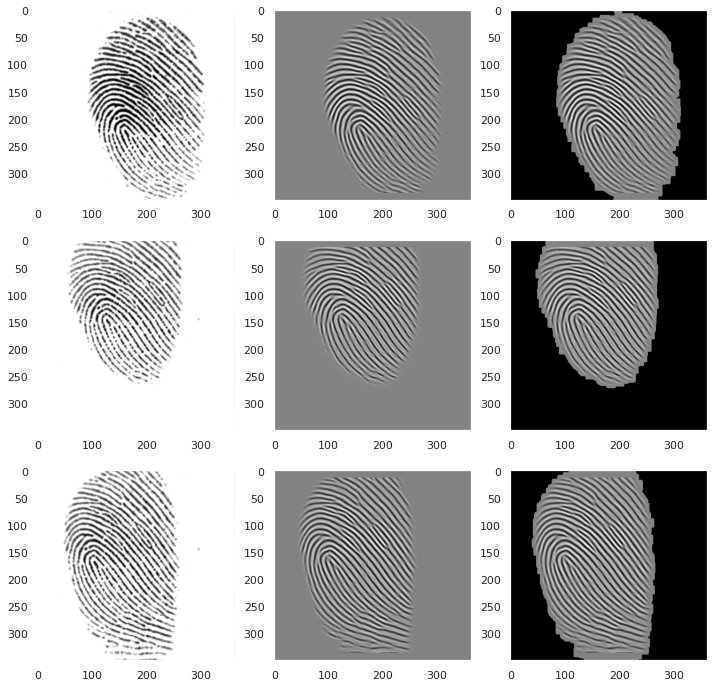

In [7]:
# Fetch or calculate enhanced images and masks
enhanced_images_path = './fprdata/DB' + str(selected_database) + '_enhanced.p'
if os.path.isfile(enhanced_images_path):
  saved_pickle_file = open(enhanced_images_path, 'rb')
  [images_enhanced, orientations, frequencies, labels, masks] = pickle.load(saved_pickle_file)
else:
  images_enhanced, orientations, frequencies, masks = enhance_images(images)
  tosave_pickle_file = open(enhanced_images_path, 'wb')
  pickle.dump([images_enhanced, orientations, frequencies, labels, masks], tosave_pickle_file)

# Visualise them (sanity check)
center_plots()
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(12,12))
for i in range(3):
  ax[i,0].imshow(images[i], cmap='gray')
  ax[i,1].imshow(images_enhanced[i], cmap='gray')
  ax[i,2].imshow(images_enhanced[i] * masks[i], cmap='gray')
plt.show()

*I want to check if the skeletons look okay. Before adapting the threshold (the adaptive one used before generating a skeleton) many of the skeletons had pretty big issues.*

*This is a kind of tuning based on the sensor that is being dealt with. The FVC databases (4 of them) each use a different sensor though comparing sensors is not the goal as the way the fingerprints were taken varied in many more ways.*

Display images for sample at index  0


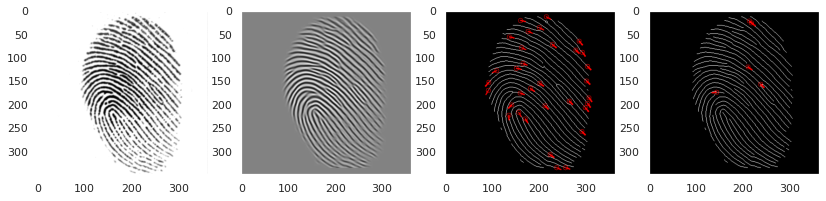

Display images for sample at index  1


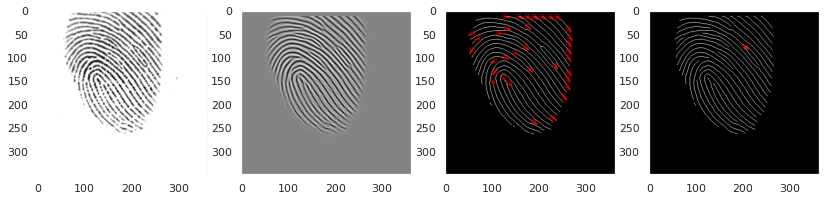

In [8]:
import fprmodules.minutiae_extraction as fm
idx = 0
cap = 2
for (i,m) in zip(images_enhanced, masks):
  if idx == cap:
    break
  (endings, bifurcations, skeleton) = fm.extractMinutiae(i, m, 41, 10)
  angles = orientations[idx]
  print('Display images for sample at index ', idx)
  fig, ax = plt.subplots(nrows=1,ncols = 4, figsize=(14,14))
  ax[0].imshow(images[idx],cmap='gray')
  ax[1].imshow(i,cmap='gray')
  # display endings
  annotated_endings = cv2.cvtColor(skeleton, cv2.COLOR_GRAY2BGR)
  for point in endings:
    angle = angles[point[0]][point[1]]
    x =  int(round(point[1] + 10 * np.cos(angle)));
    y =  int(round(point[0] + 10 * np.sin(angle)));
    cv2.line(annotated_endings, (point[1],point[0]), (x,y), (255,0,0), thickness=2)
    cv2.circle(annotated_endings, tuple(point[::-1]), 5, (255,0,0))
  ax[2].imshow(annotated_endings)
  # display bifurcations
  annotated_bifurcations = cv2.cvtColor(skeleton, cv2.COLOR_GRAY2BGR)
  for point in bifurcations:
    angle = angles[point[0]][point[1]]
    x =  int(round(point[1] + 10 * np.cos(angle)));
    y =  int(round(point[0] + 10 * np.sin(angle)));
    cv2.line(annotated_bifurcations, (point[1],point[0]), (x,y), (255,0,0), thickness=2)
    cv2.circle(annotated_bifurcations, tuple(point[::-1]), 5, (255,0,0))
  ax[3].imshow(annotated_bifurcations)
  plt.show()
  idx = idx + 1

### Keypoint Extraction and matching

#### Keypoint detection and feature description

In [0]:
def detect_keypoints(image, detector_name):
    """
    Detect keypoints in the given image and describe them.
    The detector (/descriptor) strategy with given name is used.
    """
    max_results = 800
    if detector_name == 'SIFT':
      dd = cv2.xfeatures2d.SIFT_create(max_results, contrastThreshold=0.02, edgeThreshold=20)
    elif detector_name == 'SURF':
      dd = cv2.xfeatures2d.SURF_create(max_results)
    #elif descriptor_name == 'FAST':
      #cv2.FastFeatureDetector_create()
    elif detector_name == 'BRIEF':
      #detector = cv2.xfeatures2d.StarDetector_create()
      detector = cv2.ORB_create(max_results)
      brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
      kp = detector.detect(image, None)
      return brief.compute(image, kp)
    elif detector_name == 'BRISK':
      dd = cv2.BRISK_create();
    else:
      dd = cv2.ORB_create(max_results)
    return dd.detectAndCompute(image, None)

def get_norm(detector_name):
  """
  Get the norm associated to the given detector.
  """
  return cv2.NORM_L2 if detector_name == 'SIFT' or detector_name == 'SURF' else cv2.NORM_HAMMING

In [0]:
# Pick a detector/descriptor.
detector_name = 'SURF' # ORB | SIFT | SURF | BRISK | BRIEF
detector_norm = get_norm(detector_name)

In [0]:
def remove_edge_kps(mask, kp, desc):
    """
    This procedure removes keypoints at the edges.
    Many false keypoints will be generated at the edge of the 
      foreground mask, since ridges seem to terminate due to the clipping.
    We remove these by a morpholigical erosion (shrinking) 
      of the foreground mask and deleting the keypoints outside.
    """
    mask_b = mask.astype(np.uint8)  #convert to an unsigned byte
    # morphological erosion
    mask_b *= 255
    mask_e = cv2.erode(mask_b, kernel = np.ones((5,5),np.uint8), iterations = 5)
    # remove keypoints and their descriptors that lie outside this 
    #   eroded mask
    kpn = [kp[i] 
            for i in range(len(kp)) 
            if mask_e.item(int(kp[i].pt[1]), int(kp[i].pt[0])) == 255
    ]
    descn = np.vstack([desc[i] 
                        for i in range(len(kp)) 
                        if mask_e.item(int(kp[i].pt[1]), int(kp[i].pt[0])) == 255
    ])
    return kpn, descn

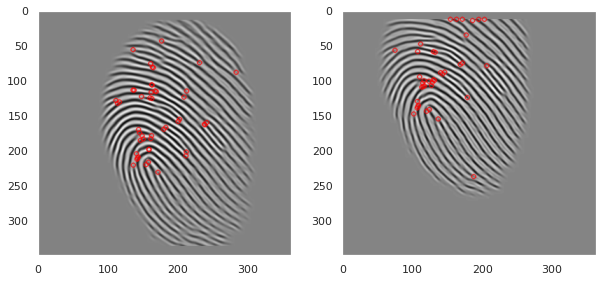

In [12]:
def find_keypoints(image, mask, detector_name):
  """
  Detect keypoints and generate descriptors for the given image.
  This also removes keypoints at the edges (of the given mask).
  """
  kp, des = detect_keypoints(image, detector_name)
  return remove_edge_kps(mask, kp, des)

def draw_keypoints(image, keypoints):
  """
  Draw the given keypoints on the given image.
  """
  return cv2.drawKeypoints(image, keypoints, None, (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)

# Find keypoints and generate descriptors (test on two images)
test_nr_1 = 0
test_nr_2 = 1
image_enhanced_1 = images_enhanced[test_nr_1]
image_enhanced_2 = images_enhanced[test_nr_2]
kp1, des1 = find_keypoints(image_enhanced_1, masks[test_nr_1], detector_name)
kp2, des2 = find_keypoints(image_enhanced_2, masks[test_nr_2], detector_name)

# Visualise the keypoints
center_plots()
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))
ax[0].imshow(draw_keypoints(image_enhanced_1, kp1))
ax[1].imshow(draw_keypoints(image_enhanced_2, kp2))
plt.show()

#### Local matching by feature vector comparison

In [0]:
def match_bruteforce_local(des1, des2, norm=cv2.NORM_HAMMING):
    """
    Returns all pairs of best matches.
    crossCheck=True only retains pairs of keypoints that are each 
      other best matching pair.
    """
    bf = cv2.BFMatcher(norm, crossCheck=True)
    matches = bf.match(des1, des2)
    matches.sort(key=lambda x: x.distance, reverse=False) # sort matches based on feature distance
    return matches

def find_matches(des1, des2, norm=cv2.NORM_HAMMING):
  """
  Find matches for the given sets of descriptors.
  """
  return match_bruteforce_local(des1, des2, norm)

def draw_matches(img1, img2, kp1, kp2, matches):
  """
  Draw the given matches on the given images.
  """
  return cv2.drawMatches(img1, kp1, img2, kp2, matches, None)

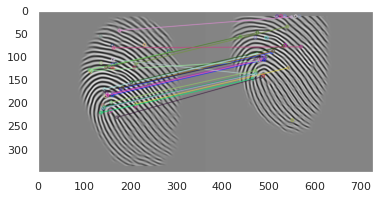

In [14]:
matches = find_matches(des1, des2, detector_norm)

center_plots()
plt.imshow(draw_matches(image_enhanced_1, image_enhanced_2, kp1, kp2, matches))
plt.show()

#### Global matching by testing geometrical consistency

In [0]:
def match_bruteforce_global(kp1, 
                            kp2, 
                            matches, 
                            good_match_percent = 0.75,
                            transform=True):
    """
    Find matches for the given sets of keypoints based on a global (affine) transformation.
    This transformation is approximated with RANSAC.
    """
    # A local function required to transform key_points by a certain 
    #   transformation matrix
    def transform_keypoints(key_points, transformation_matrix):
        # convert keypoint list to Nx1x2 matrix
        mat_points = cv2.KeyPoint.convert(key_points).reshape(-1,1,2)
        # transform points 
        mat_reg_points = cv2.transform(mat_points, transformation_matrix)
        # return transformed keypoint list
        return cv2.KeyPoint.convert(mat_reg_points)    

    # Select the best x percent best matches (on local feature vector 
    #   level) for further global comparison.
    num_good_matches = int(len(matches) * good_match_percent)
    good_matches = matches[:num_good_matches]
   
    # Retain only the keypoints associated to the best matches 
    src_pts = np.float32(
        [kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32(
        [kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Estimate an optimal 2D affine transformation with 4 degrees of 
    #   freedom, limited to combinations of translation, rotation, and 
    #   uniform scaling.
    # This is the core of the global consistency check: if we find the 
    #   correct transformation (which we expect for genuine pairs and 
    #   not for imposter pairs), we can use it as an additional check by 
    #   verifying the geometrical quality of the match.
    
    # M stores the optimal transformation
    # inliers stores the indices of the subset of points that were 
    #   finally used to calculate the optimal transformation.
    # "inliers: Output vector of same length as number of points, 
    #   indicating which points are inliers."
    M, inliers = cv2.estimateAffinePartial2D(src_pts, 
                                             dst_pts, 
                                             method=cv2.RANSAC, 
                                             confidence=0.9, 
                                             ransacReprojThreshold=10.0, 
                                             maxIters=5000, 
                                             refineIters=10)
    
    # Get the inlier matches
    matched = [x for x,y in zip(good_matches, inliers) if y[0] == 1]

    # The optimal transformation is only correct for genuine pairs in 
    #   about 75% of cases (experimentally on dataset DB1).
    # One can build additional checks about the validity of the 
    #   transformation, e.g. too large translations, rotations and/or 
    #   scale factors.
    
    # A simple one is to test the number of keypoints that were used 
    #   in calculating the transformation. 
    # If this number is is too small, then the transformation is 
    #   most possibly unreliable. 
    # In that case, we reset the transformation to the identity.
    if np.sum(inliers) < 5:
        M = np.eye(2, 3, dtype=np.float32)

    return (transform_keypoints(kp1, M) if transform else kp1), matched, M

def visualise_matches_transformation(kp1, kp2, img1, img2, matches, verbose=False):
  """
  Visualisation of matches after affine transformation.
  """
  kp1_reg, matched, M = match_bruteforce_global(kp1, kp2, matches)
  height, width = img2.shape[:2]
  img1_reg = cv2.warpAffine(img1, M, (width, height))
  plt.imshow(draw_matches(img1_reg, img2, kp1_reg, kp2, matched)) # only the inlier matches (matched) are shown.
  plt.show()
  if verbose:
    print("Affine_#inliers:{}".format(len(matched)))
  return img1_reg, kp1_reg

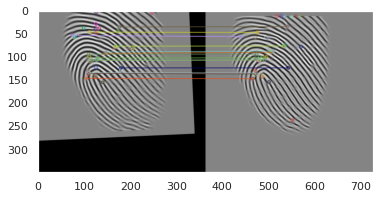

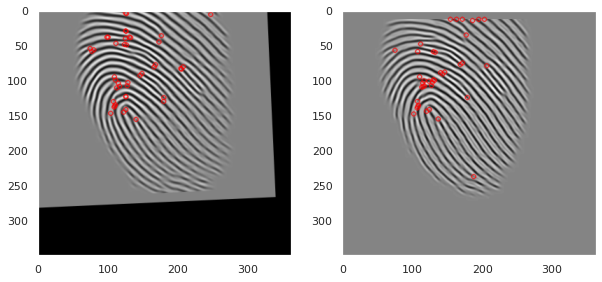

In [16]:
# Note; the hypothesis is that the transformation will be OK most of the 
#   time when it comes to genuine pairs, not for imposter pairs. 
img1_reg, kp1_reg = visualise_matches_transformation(kp1, 
                                                     kp2,
                                                     image_enhanced_1,
                                                     image_enhanced_2,
                                                     matches,
                                                     verbose=False)

# Show all keypoints after geometric matching.
center_plots()
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))
ax[0].imshow(draw_keypoints(img1_reg, kp1_reg))
ax[1].imshow(draw_keypoints(image_enhanced_2, kp2))
plt.show()

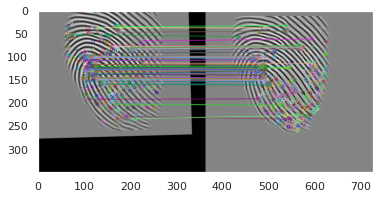

Affine_#inliers:63


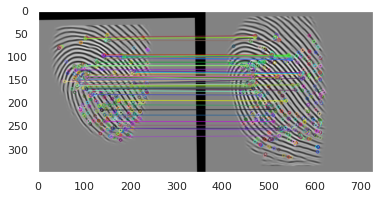

Affine_#inliers:70


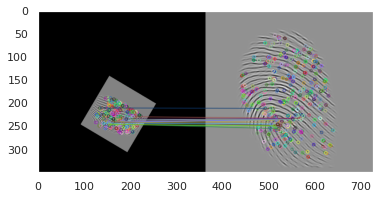

Affine_#inliers:17


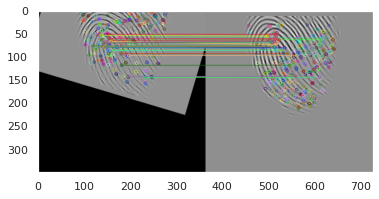

Affine_#inliers:29


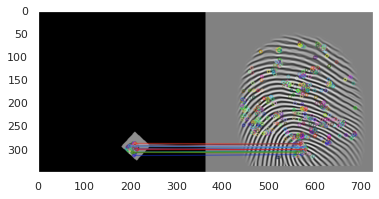

Affine_#inliers:16


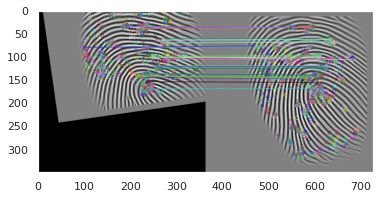

Affine_#inliers:30


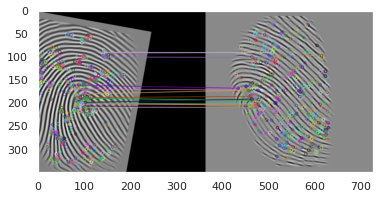

Affine_#inliers:16


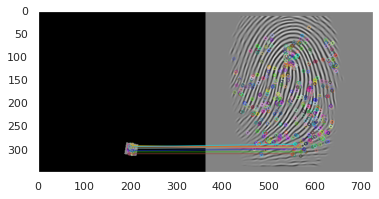

Affine_#inliers:11


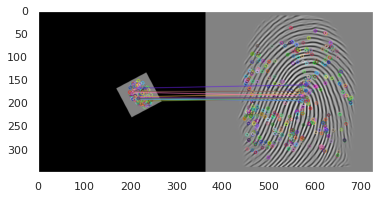

Affine_#inliers:12


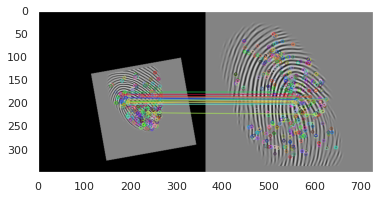

Affine_#inliers:18


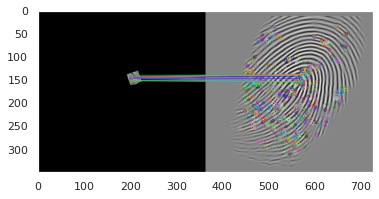

Affine_#inliers:15


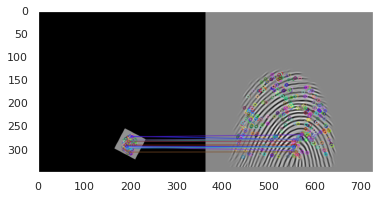

Affine_#inliers:12


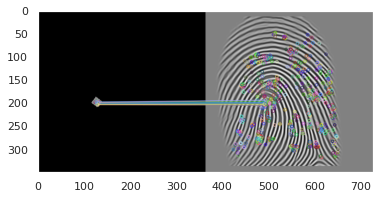

Affine_#inliers:13


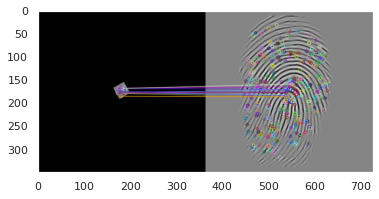

Affine_#inliers:14


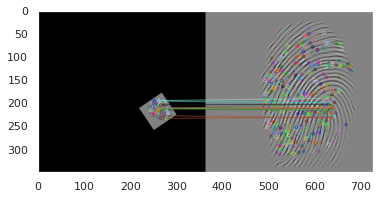

Affine_#inliers:12


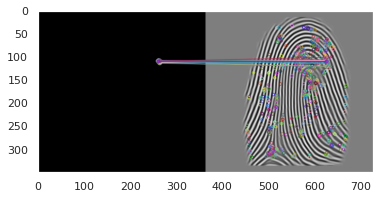

Affine_#inliers:14


In [17]:
center_plots()
detector_name = 'ORB'
for t1, t2 in zip(list(range(8)) + list(range(8)),list(range(1,17))):
  kp1, des1 = find_keypoints(images_enhanced[t1], masks[t1], detector_name)
  kp2, des2 = find_keypoints(images_enhanced[t2], masks[t2], detector_name)
  matches = find_matches(des1, des2, get_norm(detector_name))
  visualise_matches_transformation(kp1, kp2, images_enhanced[t1], images_enhanced[t2], matches, True)

## Tasks

#### Task 1 Test different Keypoint Detectors/Descriptors

* OpenCV provides different KeyPoint detectors and descriptors (ORB, SIFT, SURF, BRIEF, ...). Briefly test, visually, which of these seem to extract relatively reliable interesting points from the fingerprints.
* Note that for some of the KeyPoint descriptors, you need to have a special licence or a full implementation. Skip if you do not have it.
* You also may have to tune the parameters of these detectors.
* But don't spend too much time on this testing step. 
* If you do have the time and the computational resources, you can compare not just visually but by calculating all through using ROC and CMC curves as evidence (Cf. task 3)

ORB :


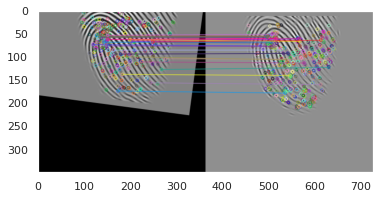

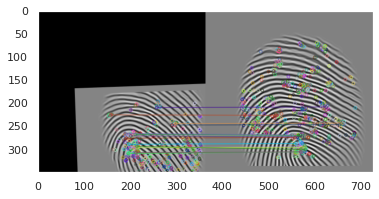

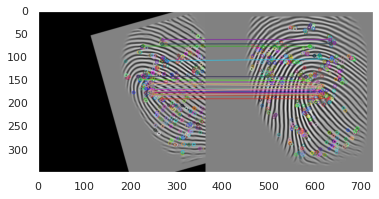

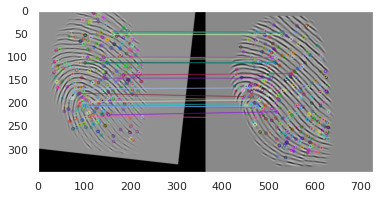

SURF :


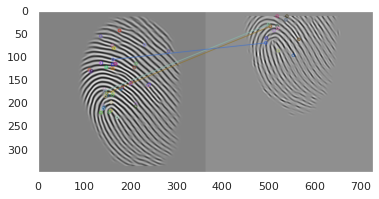

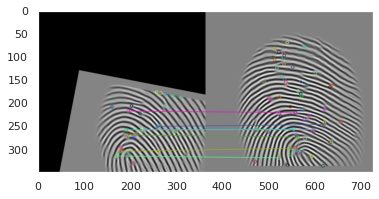

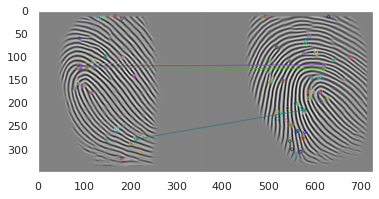

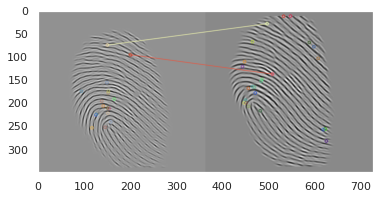

SIFT :


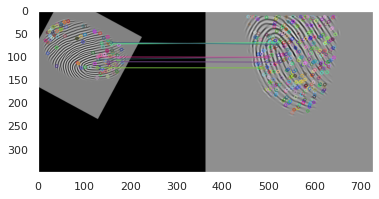

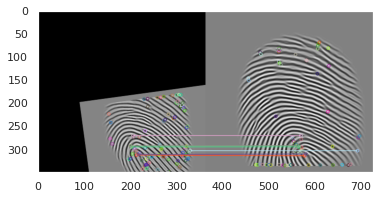

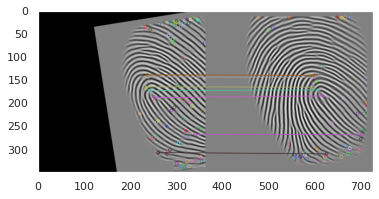

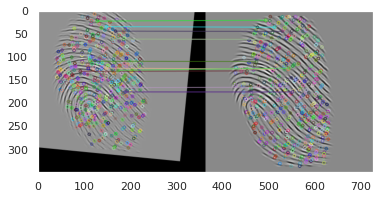

BRIEF :


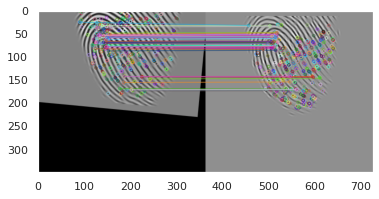

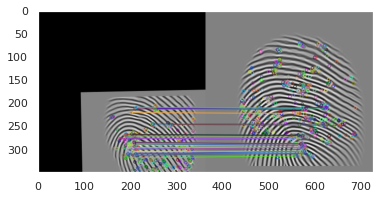

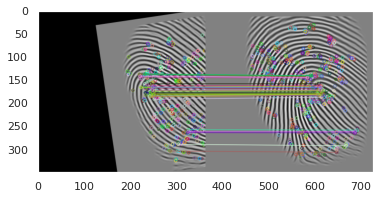

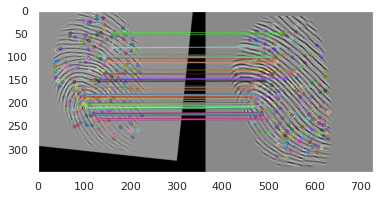

BRISK :


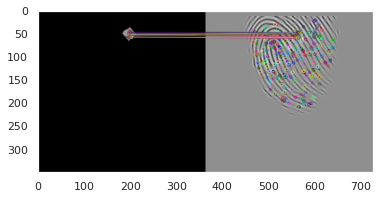

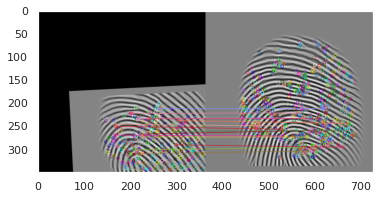

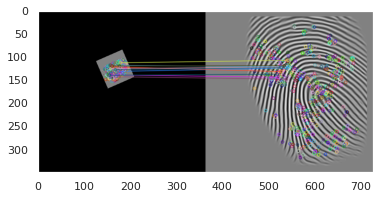

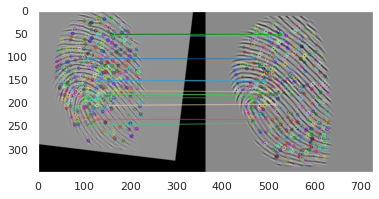

In [18]:
center_plots()
for detector_name in ['ORB', 'SURF', 'SIFT', 'BRIEF', 'BRISK']:
  print(detector_name + ' :')
  for t1, t2 in zip([0,1,2,3], [4,5,6,7]):
    kp1, des1 = find_keypoints(images_enhanced[t1], masks[t1], detector_name)
    kp2, des2 = find_keypoints(images_enhanced[t2], masks[t2], detector_name)
    matches = find_matches(des1, des2, get_norm(detector_name))
    visualise_matches_transformation(kp1, kp2, images_enhanced[t1], images_enhanced[t2], matches, False)

*From this - limited - set of results it looks like ORB, SIFT and BRIEF (using ORB as a detector) are worth experimenting with further. All 3 are  evaluated in what follows.*

*Minutiae look like a safer bet because they deal specifically with fingerprints while the feature descriptors are designed for very broad usage.*

In [0]:
selected_descriptors = ['ORB', 'SIFT', 'BRIEF']

#### Task 2. Determine a matching function
    
You have been given code to calculate matches on a local level and to calculate an affine transformation that allows a more global consistency check. 
    
Define and test different matching functions that make use of these two-level features.
    
1. a function based only on the local features (e.g. number of pairs with feature distance below a set distance threshold, the sum or mean of the feature distance of the best N pairs, or any other function you think is a good candidate)
2. a function based on the geometrical distances between pairs of KeyPoints after affine transformation. For instance, you can take again a brute force matcher that, instead of pairwise feature descriptor distances, computes pairwise geometrical distances between the two point sets. From there on you can then define different measures (number of distances below a threshold or sum/mean of distances, ...). You can also limit the number of point pairs to apply this to to the matching pairs that result from the local match and/or the ones that are returned as 'matched' by the Ransac procedure. 
3. any combination of local and global match metrics

In [0]:
def score_local(matches, nb_matches=10):
  """
  Takes the mean of the first `nb_matches` matches,
    or returns a large number (2^12) if there aren't any.
  """
  matches.sort(key=lambda x: x.distance, reverse=False)
  nb_matches = min(nb_matches, len(matches))
  if nb_matches == 0:
    return 2**12
  nb_selected = min(len(matches),nb_matches)
  return sum(m.distance for m in matches[:nb_selected]) / nb_selected

def score_local2(matches):
  """
  Takes the number of matches with distance smaller than a certain number.
  Keep in mind that distances depend on the norm.
  """
  return sum(m.distance < 75 for m in matches)

def get_score_local(i, j, descriptor, matcher):
  """
  Helper function for getting the local score for two images using the given descriptor / matcher.
  """
  _, des_i = find_keypoints(images[i], masks[i], descriptor)
  _, des_j = find_keypoints(images[j], masks[j], descriptor)
  matches = matcher.match(des_i, des_j)
  return score_local(matches)

In [0]:
def score_global(matches, nb_matches=10):
  """
  Takes the mean of the first `nb_matches` matches,
    or returns a large number (2^12) if there aren't any.
  """
  matches.sort(key=lambda x: x.distance, reverse=False)
  nb_matches = min(nb_matches, len(matches))
  if nb_matches == 0:
    return 2**12
  nb_selected = min(len(matches),nb_matches)
  return sum(m.distance for m in matches[:nb_selected]) / nb_selected

def score_global2(matches):
  """
  Takes the number of matches with distance smaller than 70.
  Keep in mind that distances depend on the norm.
  """
  return sum(m.distance < 120 for m in matches)

def get_score_global(i, j, descriptor, matcher, basic=True):
  """
  Helper function for getting the global score for two images using the given descriptor / matcher.
  """
  # first get keypoints and descriptors, then match them
  kp_i, des_i = find_keypoints(images[i], masks[i], descriptor)
  kp_j, des_j = find_keypoints(images[j], masks[j], descriptor)
  matches = matcher.match(des_i, des_j)
  # determine a proper affine transformation
  kpi_transformed, matched, _ = match_bruteforce_global(kp_i, kp_j, matches)
  if basic:
    if len(matched) < 10:
      return 2**12
    else:
      return sum([matched[i].distance for i in range(10)])
  # turn the keypoints into descriptors which are arrays of dimension 2
  des_i_new = np.float32([kpi_transformed[m.queryIdx].pt for m in matched]).reshape(-1, 2)
  des_j_new = np.float32([kp_j[m.trainIdx].pt for m in matched]).reshape(-1, 2)
  global_matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
  global_matches = global_matcher.match(des_i_new, des_j_new)
  return score_global2(global_matches)

#### Task 3 Test complete system for authentication and identification scenario's

* Choose (at least) one of the databases provided
* calculate the ROC (false match to false non match rate) for an authentication scenario 
* and a Cumulative Match Characteristic (CMC) curve, which plots the rank (order in the candidate list) on the x-axis and the probability of identification at that or better rank on the y-axis. Feel free to reuse your code of the previous assignment!

* Of course you can calculate and store the features upfront before starting the validation procedures.
* Also follow the pipeline and the datastructure of the first assignment on validation, where you calculated genuine and imposter scores (cf. the genuine_id and scores lists that you generated)

*First I want to comment on how to compare results with the FVC 2000 results. Their website provides a technical report with
details on how to calculate performance. The idea is to calculate template images for all images I<sub>ij</sub> where i=0..10 and
j=1..7. Then from these templates genuine and imposter scores are determined. That way FMR and FNMR can be calculated.*

*Hereunder I first calculate the similarity matrix. Each element S<sub>ij</sub> in this matrix compares image i with image j and
gives a similarity score. Genuine scores are not those on the diagonal anymore but the similarities for images that are 
fingerprints of the same person. This is due to the fact that there are multiple samples per person. In the FVC competition they do **not** include the diagonal in the evaluation.*

In [0]:
def calculate_similarity_matrix(images, sfunc, cfunc, aggfunc=(lambda x:np.mean(x,axis=0)), normalize=True, fvc_style=True):
  """
  Calculate similarity matrices for various strategies.
  Note that genuine/imposter score don't correspond to the diagonal if fvc_style is used.
  @param sfunc Function to calculate scores for given pair of images.
                Needs to return a numerical value or a list of numerical values.
  @param cfunc Function to convert score results. This is needed to make normalisation possible.
  @param fvc_style Whether the FVC 2000 genuine/imposter score calculation is used.
  """
  people = 10
  samples = 8
  nb_pairs = int(samples*samples/2 + people/2)
  # calculate similarity matrix & aggregate across z-axis
  matrix = np.zeros((people, people))
  genuine_scores = []
  imposter_scores = []
  for a in tqdm_notebook(range(people)):
    for b in range(a,people):
      if a == b:
        pair_scores = [sfunc(samples*a+i,samples*b+j) for i in range(samples) for j in range(samples) if i < j]
        genuine_scores.append(pair_scores)
        #pair_scores = pair_scores + [sfunc(samples*a+i,samples*a+i) for i in range(samples)] # samples * [1]
      else:
        pair_scores = [sfunc(i+samples*a,j+samples*b) for i in range(samples) for j in range(samples) if i <= j]
        imposter_scores.append(pair_scores)
      matrix[a,b] = aggfunc(pair_scores)
      matrix[b,a] = matrix[a,b]
  # post-process
  genuine_scores = np.asarray(genuine_scores).flatten()
  imposter_scores = np.asarray(imposter_scores).flatten()
  if normalize:
    mins = np.min(matrix)
    matrix = (matrix-mins) / (np.max(matrix)-mins)
    scores = np.concatenate((genuine_scores, imposter_scores), axis=None)
    min_scores = np.min(scores)
    genuine_scores = (genuine_scores-min_scores) / (np.max(scores) - min_scores)
    imposter_scores = (imposter_scores-min_scores) / (np.max(scores) - min_scores)
  matrix = cfunc(matrix)
  genuine_scores = cfunc(genuine_scores)
  imposter_scores = cfunc(imposter_scores)
  # build genuine & imposter score masks
  if not(fvc_style):
    genuine_scores = np.diag(matrix)
    imposter_scores = matrix[np.triu_indices(people)]
  return matrix, genuine_scores, imposter_scores

# Predefined function combos
func_combos = [
  ('LOCAL', get_score_local, lambda t: 1-t), 
  ('GLOBAL', get_score_global, lambda t: 1-t), 
]

In [0]:
def plot_distributions(genuine, imposter):
  """
  Helper function for plotting distribution of genuine - & imposter scores.
  """
  kwargs = dict(histtype='step', density=True, bins=45)
  figure, axes = plt.subplots(ncols=1, figsize=(16,4))
  axes.hist(genuine, color=(0.4,0.7,0.2), label='Genuine', **kwargs)
  axes.hist(imposter, color=(0.75,0.3,0.2), label='Imposter', **kwargs)
  plt.show()

In [0]:
def full_roc(genuine_id, scores):
  """
  Calculate the full ROC (consider all thresholds).
  This also returns the EER(s) the way it is described in the technical report for FVC 2000.
  http://bias.csr.unibo.it/fvc2000/perfeval.asp
  I tested this implementation but ended up not using it because it's less convenient (doesn't give a way
    to find the AUC directly) and because the EER is about the same as that found through sklearn.
  """
  genuine = genuine_id.tolist()
  true_positives = genuine.count(1)
  true_negatives = 0
  false_positives = genuine.count(0)
  false_negatives = 0
  is_genuine = 0
  fprs = []
  fnrs = []
  tprs = []
  update = 0
  for (threshold,index) in sorted((s,i) for i,s in enumerate(scores)):
    if update:
      true_positives = true_positives - is_genuine
      true_negatives = true_negatives + (1-is_genuine)
      false_positives = false_positives - (1-is_genuine)
      false_negatives = false_negatives + is_genuine
    else:
      update = 1
    fpr = false_positives / (false_positives + true_negatives)
    fnr = false_negatives / (false_negatives + true_positives)
    fprs.append(fpr)
    fnrs.append(fnr)
    tprs.append(1-fnr)
    is_genuine = (genuine[index] == 1)
  low = max([i for i in range(len(fprs)) if fnrs[i] <= fprs[i]])
  high = max([i for i in range(len(fprs)) if fnrs[i] >= fprs[i]])
  (eer_low, eer_high) = (fnrs[low],fprs[low]) if fnrs[low] + fprs[low] <= fnrs[high] + fprs[high] else (fprs[high],fnrs[high])
  eer = (eer_low + eer_high) / 2
  return fprs, tprs, scores, eer

*SIFT is slow and it is also not performing all that well. ORB and BRIEF do better. Therefor only ORB, BRIEF and minutiae are used in future experiments.*

In [0]:
#genuine_scores, imposter_scores = calculate_similarity_matrix(images_enhanced, masks, descriptor='SIFT', score_function=get_score_local)
#plot_distributions(genuine_scores, imposter_scores)

Size of genuine/imposter : 280,1620
Distribution for descriptor ORB, strategy LOCAL


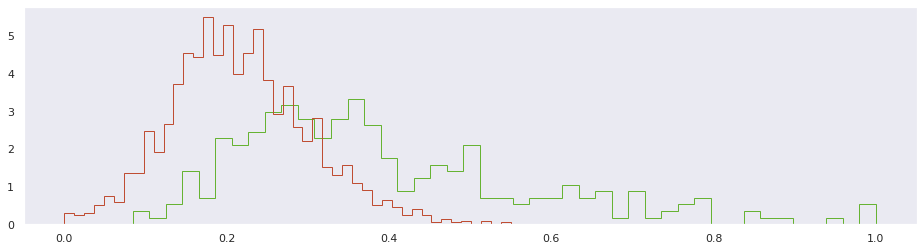

Size of genuine/imposter : 280,1620
Distribution for descriptor ORB, strategy GLOBAL


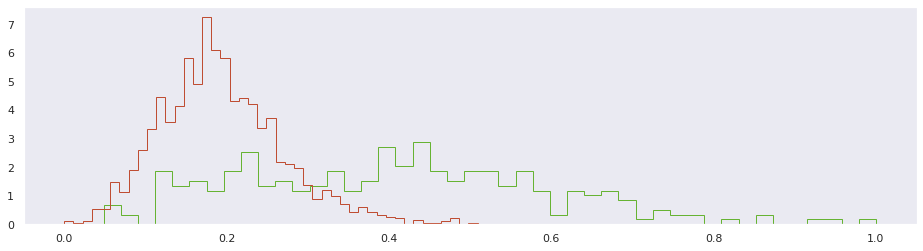

Size of genuine/imposter : 280,1620
Distribution for descriptor ORB, strategy COMPOSITE


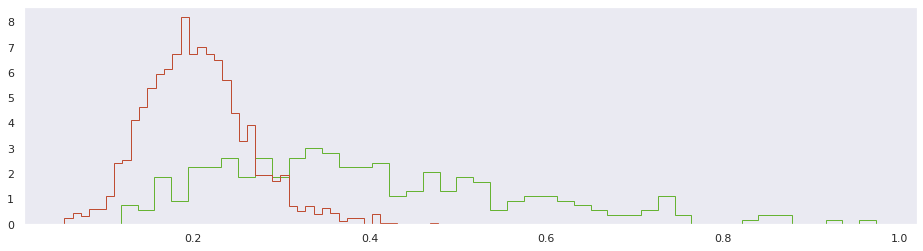

Size of genuine/imposter : 280,1620
Distribution for descriptor BRIEF, strategy LOCAL


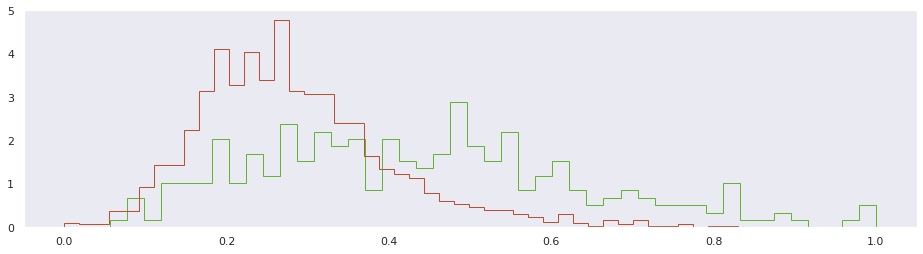

Size of genuine/imposter : 280,1620
Distribution for descriptor BRIEF, strategy GLOBAL


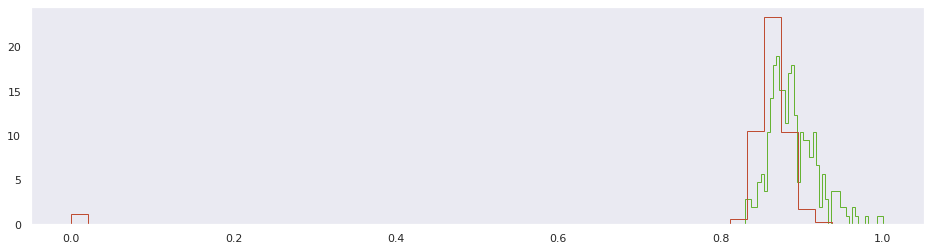

Size of genuine/imposter : 280,1620
Distribution for descriptor BRIEF, strategy COMPOSITE


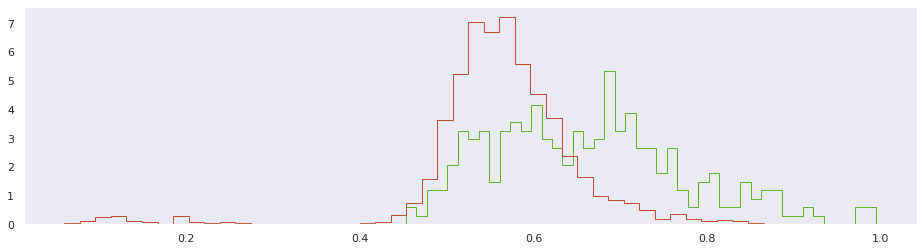

In [26]:
import os.path

# Fetch scores from disk and plot distributions
scores_dict = {}
for descriptor in ['ORB', 'BRIEF']:
  matcher =  cv2.BFMatcher(get_norm(descriptor), crossCheck=True)
  combo = []
  for (strategy, sfunc, cfunc) in func_combos:
    matrix_file = "./fprdata/DB" + str(selected_database) + "_" + descriptor + '_' + strategy + "_fvcstyle.p"
    if os.path.isfile(matrix_file):
      pickle_file = open(matrix_file, "rb")
      s, g, i = pickle.load(pickle_file)
    else:
      sfunc_md = lambda i,j: sfunc(i, j, descriptor, matcher)
      s, g, i = calculate_similarity_matrix(images_enhanced, sfunc_md, cfunc)
      pickle_file = open(matrix_file, "wb")
      pickle.dump((s,g,i), pickle_file)
    combo.append([s,g,i])
    scores_dict[descriptor + '_' + strategy] = (s, g, i)
    print("Size of genuine/imposter : " + str(len(g)) + "," + str(len(i))) # should be 280 and 2880
    print("Distribution for descriptor " + descriptor + ", strategy " + strategy)
    plot_distributions(g,i)
  [s,g,i] = np.mean(combo, axis=0)
  scores_dict[descriptor + '_COMPOSITE'] = (s, g, i)
  print("Size of genuine/imposter : " + str(len(g)) + "," + str(len(i))) # should be 280 and 2880
  print("Distribution for descriptor " + descriptor + ", strategy COMPOSITE")
  plot_distributions(g,i)

EER for ORB_LOCAL : ( 0.2580246913580247 )
AUC for ORB_LOCAL :  0.8248677248677249
EER for ORB_GLOBAL : ( 0.2351851851851852 )
AUC for ORB_GLOBAL :  0.8430753968253968
EER for ORB_COMPOSITE : ( 0.2080246913580247 )
AUC for ORB_COMPOSITE :  0.8753968253968253
EER for BRIEF_LOCAL : ( 0.3216049382716049 )
AUC for BRIEF_LOCAL :  0.7401752645502646
EER for BRIEF_GLOBAL : ( 0.32037037037037036 )
AUC for BRIEF_GLOBAL :  0.761902557319224
EER for BRIEF_COMPOSITE : ( 0.304320987654321 )
AUC for BRIEF_COMPOSITE :  0.753561507936508


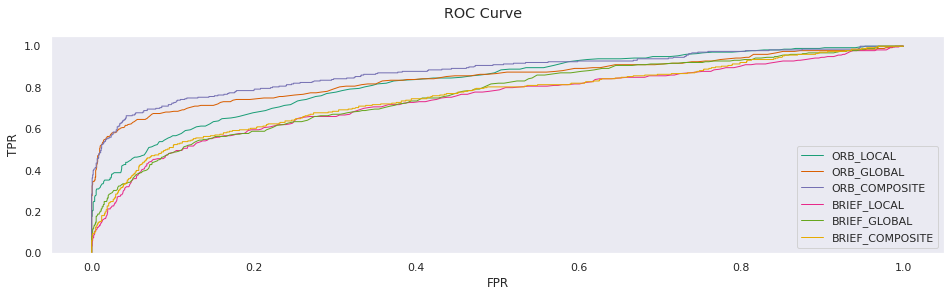

In [189]:
# Visualise the ROC curves
from sklearn.metrics import roc_auc_score

def plot_roc(genuine, imposter, color=(0,1,0), label='', axes=None):
  """Plot the ROC curve for the given genuine scores, imposter scores"""
  genuine_id = np.hstack((np.ones(len(genuine)), np.zeros(len(imposter))))
  scores = np.hstack((genuine, imposter))
  fpr, tpr, thresholds = roc_curve(genuine_id, scores)
  min_index = np.argmin(abs((1-tpr)-fpr))
  print("EER for " + label + " : (", fpr[min_index], ")") #, thresholds[min_index], fpr[min_index], ")")
  print("AUC for " + label + " : ", roc_auc_score(genuine_id, scores))
  if axes is None:
    center_plots()
    figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
    figure.suptitle('ROC Curve')
    axes.plot(fpr, tpr, color=color, lw=1, label=label)
    axes.set(xlabel='FPR', ylabel='TPR', ylim=[0.0,1.05])
    axes.legend()
    plt.show()
  else:
    axes.plot(fpr, tpr, color=color, lw=1, label=label) # np.random.rand(3,)

colors = plt.get_cmap("Dark2").colors
center_plots()
figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
figure.suptitle('ROC Curve')
color_idx = 0
for strategy in scores_dict.keys():
  _, genuine_scores, imposter_scores = scores_dict[strategy]
  plot_roc(genuine_scores, imposter_scores, color=colors[color_idx], label=strategy, axes=axes)
  color_idx = color_idx + 1 
axes.set(xlabel='FPR', ylabel='TPR', ylim=[0.0,1.05])
axes.legend()
plt.show()

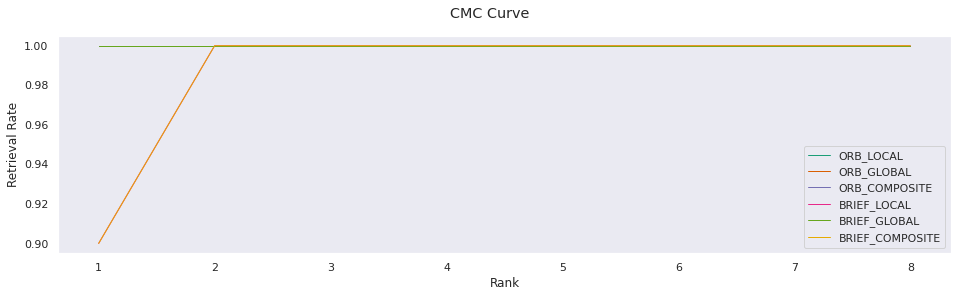

In [126]:
def CMC(similarity_matrix, n_ranks=8):
  """
  Calculate the Cumulative Matching Characteristic (CMC) curve.
  """
  cmc = [0] * n_ranks
  for (i,row) in enumerate(similarity_matrix):
    rank = len(row) - 1 - np.argsort(np.argsort(row))[i]
    if rank < n_ranks:
      cmc[rank] += 1
    prev = 0
  for i in range(n_ranks):
    prev = cmc[i] + prev
    cmc[i] = prev / similarity_matrix.shape[0]
  return cmc

def plot_cmc(similarity_matrix, color=(0,1,0), label='', axes=None):
  """Plot the CMC curve for the given similarity matrix."""
  cmc = CMC(similarity_matrix)
  if axes is None:
    figure, axes = plt.subplots(ncols=1, figsize=(16,4))
    figure.suptitle('CMC Curve')
    axes.plot(list(range(1,len(cmc)+1)), cmc, color=color, lw=1, label=label)
    axes.set(xlabel='Rank', ylabel='Retrieval Rate')
    axes.legend()
    plt.show()
  else:
    axes.plot(list(range(1,len(cmc)+1)), cmc, color=color, lw=1, label=label)

# Visualise CMC plots
colors = plt.get_cmap("Dark2").colors
color_idx = 0
center_plots()
figure, axes = plt.subplots(ncols=1, figsize=(16,4))
figure.suptitle('CMC Curve')
for strategy in scores_dict.keys():
  matrix, _, _ = scores_dict[strategy]
  plot_cmc(matrix, color=colors[color_idx], label=strategy, axes=axes)
  color_idx = color_idx + 1
axes.set(xlabel='Rank', ylabel='Retrieval Rate')
axes.legend()
plt.show()

*Something to be noted is that in the first part of the assignment the gallery was taken to be the whole row. Normally the CMC is computed for a gallery (a probe is matched with the templates in the gallery and the rank is calculated this way). The gallery consists of different individuals. So initially I took the gallery to be the set of first pictures of every individual (10 in total). Then I matched all other pictures ('probes') with this gallery and plotted probabilities in terms of the ranks. This is based on Bolle's book 'Guide to Biometrics' when treating a 1:m biometric search engine.*

*Also in the case of face recognition a gallery (well, virtual gallery) and probe testing strategy is used where the gallery consists of different individuals. This is dealt with later.*

*Comparison of EERs was done the way the FVC 2000 specified in their technical report.*

*Later on I switched to code for the CMC curves such that the similarity matrix is a 10x10 matrix where each entry corresponds to a pair of users and all their samples are compared (except for the diagonal where identical samples aren't considered). Then the average score is taken. The CMC curve looks entirely different because of this, it looks much better. The question is whether this gives a realistic representation. What it tells us is that on average genuine scores are higher and when you bunch a few genuine scores together the chances of that bunch having a lower total score than that of an equally large bunch of imposter scores is very low. If there are any outliers these outlier cannot be detected in the curve because the other scores for the same entry in the similarity matrix tend to mask the problem.*

EER for BRIEF_COMPOSITE : ( 0.17592592592592593 )
AUC for BRIEF_COMPOSITE :  0.8900639329805997


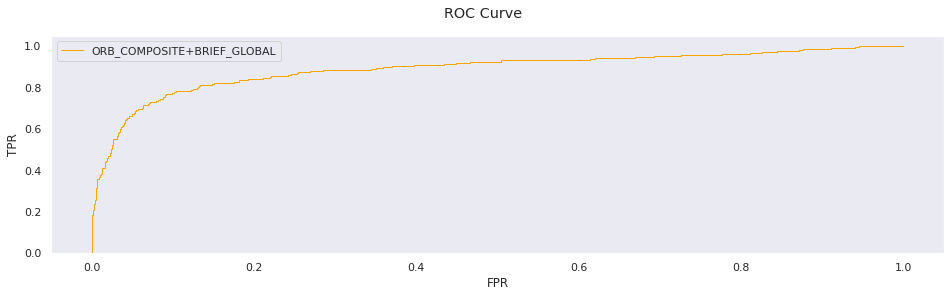

In [187]:
# Visualisation of ROC curve for ensemble of the two best (in the sense of EER) ones
center_plots()
figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
figure.suptitle('ROC Curve')
_, genuine_scores_1, imposter_scores_1 = scores_dict['ORB_COMPOSITE']
_, genuine_scores_2, imposter_scores_2 = scores_dict['BRIEF_COMPOSITE']
genuine_scores = [(a + b)/2 for (a,b) in zip(genuine_scores_1,genuine_scores_2)]
imposter_scores = [(a + b)/2 for (a,b) in zip(imposter_scores_1,imposter_scores_2)]
genuine_id = np.hstack((np.ones(len(genuine_scores)), np.zeros(len(imposter_scores))))
scores = np.hstack((genuine_scores, imposter_scores))
use_sklearn_roc = True
if use_sklearn_roc:
  fpr, tpr, thresholds = roc_curve(genuine_id, scores)
  min_index = np.argmin(abs((1-tpr)-fpr))
  print("EER for " + strategy + " : (", fpr[min_index], ")") #, thresholds[min_index], fpr[min_index], ")")
  print("AUC for " + strategy + " : ", roc_auc_score(genuine_id, scores))
else: # here I tested my implementation and it worked with the EER being almost the same
  fpr, tpr, thresholds, eer = full_roc(genuine_id, scores)
  print("EER for " + strategy + " : (", eer, ")")
axes.plot(fpr, tpr, color='orange', lw=1, label='ORB_COMPOSITE+BRIEF_GLOBAL') # np.random.rand(3,)
axes.set(xlabel='FPR', ylabel='TPR', ylim=[0.0,1.05])
axes.legend()
plt.show()

*In general the results are similar to those seen in the early visualisations and cannot compete particularly well with the results of the FVC competition. ORB appears to outperform BRIEF though together they achieve more than each separately.*

#### Task 4 Discuss your results
    
* which parts are critical?
* given more time, how would you improve?
* compare your results to the results that are available [online](http://bias.csr.unibo.it/fvc2002/results.asp) 

*For now the results are not particularly satisfactory though I found them quite surprising given the fact that the detectors/descriptors are meant for broad usage. The EER is amongst the worst in the competition yet the performance is much better than random-guess algorithms. Also to be noted is the fact that the AUC is decent and this is more telling than in the previous notebook as there's not as much class imbalance.*

*All parts of the algorithm appear to be crucial, here are some comments for the various steps :*

*   *The enhancement : results got significantly better as I fixed a bug in the provided notebook which led some images to be poorly enhanced. Toying with the parameters of the parameters used throughout the enhancement also strongly affects results but it is not straightforward. These parameters are also probably best tuned on a sensor-by-sensor basis so in a way tuning them for one database may be seen as 'overfitting' which wouldn't be a problem if the algorithm is being built with that sensor in mind.*
*   *The keypoint detector and descriptor, obviously (as per the results overall). Retaining enough features (by tuning the corresponding parameter for the keypoint detectors) is important.*
*   *Though the enhancement is quite successful it looks like the matching is too weak to distinguish imposters from genuine scores properly.*

*And of course, an ensemble is always a nice thing to use ; it's simple and tends to improve results significantly. The downside is that it's slower, which may or may not be a problem depending on the use case.*

*In what follows I experiment with two other things : minutiae and the Poincaré index to try and improve the results. The idea is to find ridge endings, bifurcations, thworls, deltas, ... rather than hoping that SIFT/ORB/... does it 'by accident'.*

#### Minutiae

*A first, obvious experiment is to try using minutiae. I use the provided code for this. I did some tests where I described the minutiae with a SIFT or other descriptor and the results improved a bit in comparison to the other detector/descriptor strategies. But not much.*

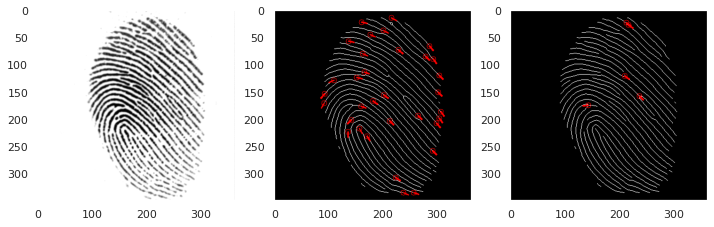

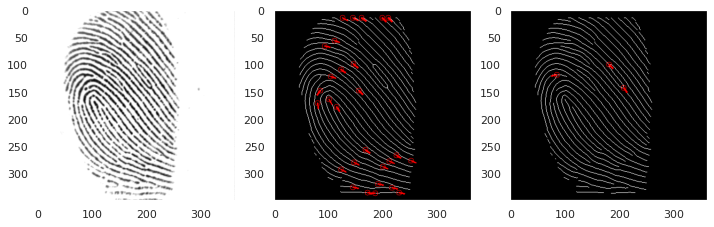

In [30]:
# Example
import fprmodules.minutiae_extraction as fme

def visualise_minutiae(image, angles, endings, bifurcations, skeleton):
  """Visualise the minutiae in the given image."""
  # visualise
  center_plots(True)
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,12))
  ax[0].imshow(image, cmap='gray')
  # display minutiae
  annotated_endings = cv2.cvtColor(skeleton, cv2.COLOR_GRAY2BGR)
  for point in endings:
    angle = angles[point[0]][point[1]]
    x =  int(round(point[1] + 10 * np.cos(angle)));
    y =  int(round(point[0] + 10 * np.sin(angle)));
    cv2.line(annotated_endings, (point[1],point[0]), (x,y), (255,0,0), thickness=2)
    cv2.circle(annotated_endings, tuple(point[::-1]), 5, (255,0,0))
  ax[1].imshow(annotated_endings)
  # display bifurcations
  annotated_bifurcations = cv2.cvtColor(skeleton, cv2.COLOR_GRAY2BGR)
  for point in bifurcations:
    angle = angles[point[0]][point[1]]
    x =  int(round(point[1] + 10 * np.cos(angle)));
    y =  int(round(point[0] + 10 * np.sin(angle)));
    cv2.line(annotated_bifurcations, (point[1],point[0]), (x,y), (255,0,0), thickness=2)
    cv2.circle(annotated_bifurcations, tuple(point[::-1]), 5, (255,0,0))
  ax[2].imshow(annotated_bifurcations)
  plt.show()

(endings, bifurcations, skeleton) = fme.extractMinutiae(images_enhanced[0], masks[0], 41, 10)
(endings_bis, bifurcations_bis, skeleton_bis) = fme.extractMinutiae(images_enhanced[2], masks[2], 41, 5)
clear_output()

visualise_minutiae(images[0], orientations[0], endings, bifurcations, skeleton)
visualise_minutiae(images[2], orientations[2], endings_bis, bifurcations_bis, skeleton_bis)

*Some things can be noted : there are some artifacts and some of those are at the edges. The latter can be removed using erosion of the mask which I do next. Another thing to note is that local matching seems somewhat dangerous (especially some of the later samples have quite some artifacts and they're hard to remove by tuning the parameters of the enhancement/skeletonisation) but global matching seems like a possibly powerful approach.*

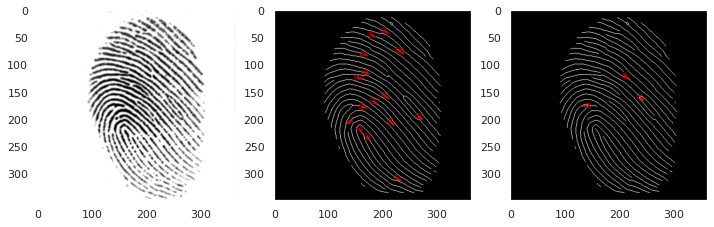

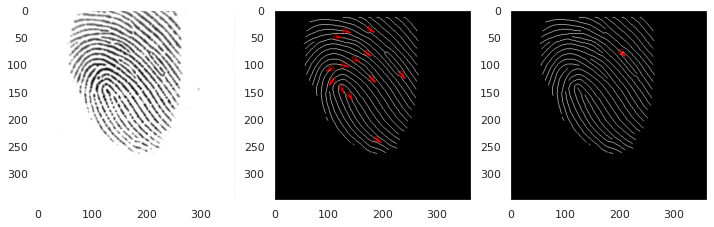

In [356]:
def remove_edge_minutiae(mask, minutiae, dx=10):
    """This procedure removes minutiae at the edges."""
    # erode mask
    mask_b = mask.astype(np.uint8)  #convert to an unsigned byte
    mask_b *= 255
    (width,height) = mask_b.shape
    mask_b = cv2.rectangle(mask_b, (0,0), (height-dx,width-dx), (0,0,0), dx)
    mask_e = cv2.erode(mask_b, kernel=np.ones((dx,dx),np.uint8), iterations=5)
    return [m for m in minutiae if mask_e.item(int(m[0]), int(m[1])) == 255] # return minutiae within eroded mask

def extract_minutiae(i, clean=True):
  """Extract the minutiae from the image at the given index (includes cleaning). Convenience procedure."""
  (endings, bifurcations, skeleton) = fme.extractMinutiae(images_enhanced[i], masks[i], 61, 10)
  if clean:
    endings = remove_edge_minutiae(masks[i], endings)
    bifurcations = remove_edge_minutiae(masks[i], bifurcations)
  return endings, bifurcations, skeleton

for i in [0,1]:
  (endings, bifurcations, skeleton) = extract_minutiae(i)            
  visualise_minutiae(images[i], orientations[i], endings, bifurcations, skeleton)

*Some of the images are poorly represented by minutiae and may not even find bifurcations. Still, a considerable overlap is visible which might render a global matching procedure useful. If not then the minutiae extraction will have to be improved, including the enhancement step.*

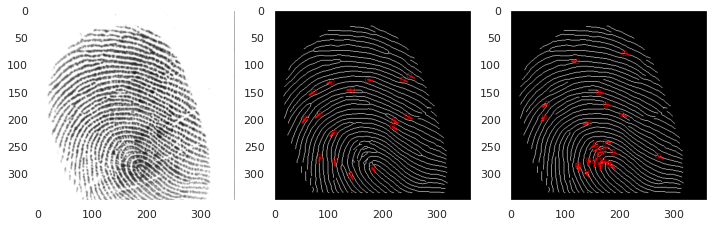

In [298]:
i = 78
(endings, bifurcations, skeleton) = extract_minutiae(i)   
visualise_minutiae(images[i], orientations[i], endings, bifurcations, skeleton)

*Note that I adapted the parameters of the adaptive thresholding pre-processing step used before skeletonisation (this has two parameters, block size and C, first is the size of the neighborhood taken into account when thresholding, C is subtracted from the mean). This influences enhancement a good deal ; some images get better, some get worse, and this also depends on the sensor. In a way these could be seen as hyperparameters that can be tuned.*

*What I do next is based on Jiang's and Yau's study [that can be found here](https://sci-hub.st/10.1109/ICPR.2000.906252).*

*The idea, rather than using point-patter matching is to represent minutiae based on nearest neighbor in such a way that the feature vector is rotation - and translation-invariant. On this basis a similarity score can be calculated.* 

In [0]:
import math 

angle_difference = lambda a, b: (a-b) if -math.pi < (a-b) <= math.pi else (2*math.pi+a-b) if (a-b) <= -math.pi else (2*math.pi-(a-b))
angle_difference_ = lambda a, b: min(angle_difference_(a,b), angle_difference_(a,math.pi-b))

def get_local_features(i, endings=None, bifurcations=None):
  """"Calculate the feature vector for the image at given index."""
  orientation = orientations[i]
  frequency = frequencies[i]
  if endings is None or bifurcations is None:
    (endings, bifurcations, _) = extract_minutiae(i)
  minutiae = endings if len(bifurcations) == 0 else np.vstack((endings,bifurcations)) # there will be > 0 endings
  angles = [orientation[minutia[0]][minutia[1]] for minutia in minutiae]
  freq = [frequency[minutia[0]][minutia[1]] for minutia in minutiae]
  return np.asarray(get_minutiae_local_features(endings, bifurcations, angles, freq))

def get_minutiae_local_features(endings, bifurcations, angles, frequencies, strategy='jiang'):
  """Calculate local feature vectors for the given minutiae. Several strategies are possible."""
  minutiae = endings if len(bifurcations) == 0 else np.vstack((endings,bifurcations)) # there will be > 0 endings
  nb = len(minutiae)
  assert nb == len(angles)
  arctan_difference = lambda i, j: angle_difference(np.arctan((minutiae[i][1]-minutiae[j][1])/(minutiae[i][0]-minutiae[j][0]+0.000001)), angles[j])
  if strategy == 'jiang':
    from sklearn.neighbors import NearestNeighbors
    neighbors = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(minutiae)
    distances, indices = neighbors.kneighbors(minutiae)
    return [(distances[i][1], distances[i][2], # note distances[0] is zero
            arctan_difference(indices[i][1],i), arctan_difference(indices[i][2],i),
            angle_difference(angles[i],angles[indices[i][1]]), angle_difference(angles[i],angles[indices[i][2]]),
            #frequencies[i], frequencies[indices[i][1]], frequencies[indices[i][2]],
            1*(i<len(endings)), 1*(indices[i][1]<len(endings)), 1*(indices[i][2]<len(endings)))
            for i in range(nb)]
  else:
    return []

def get_similarities(feature_vectors_i, feature_vectors_j, full=False):
  """Calculate the weighted difference in feature vector based on Jiang's study."""
  similarities = {}
  matches = []
  w = 0.3*180/math.pi
  bl = 54
  for i in range(len(feature_vectors_i)):
    for j in range(len(feature_vectors_j)):
      f_i = feature_vectors_i[i]
      f_j = feature_vectors_j[j]
      difference = abs(f_i - f_j)
      difference[2:6] = [abs(angle_difference(a,b)) for (a,b) in zip(f_i[2:6],f_j[2:6])] # don't forget the abs!
      weighted_difference = sum(np.multiply(difference, [1,1,w,w,w,w,3,3,3]))
      if weighted_difference < bl:
        similarity = (bl - weighted_difference) / bl
        if full:
          matches.append((weighted_difference,i,j))
        else:
          matches.append(weighted_difference)
      else:
        similarity = 0
      similarities[str(i)+"-"+str(j)] = similarity
  return (similarities, matches)

def draw_minutiae_matches(matches, i, j):
  """Tool for visualising the matches of two fingerprint images."""
  (endings_i, bifurcations_i, skeleton_i) = extract_minutiae(i)
  (endings_j, bifurcations_j, skeleton_j) = extract_minutiae(j)
  for (d,a,b) in matches:
    draw_minutia(i, [a], endings_i, bifurcations_i, skeleton_i)
    draw_minutia(j, [b], endings_j, bifurcations_j, skeleton_j)

def draw_minutia(i, ms, endings, bifurcations, skeleton):
  """Tool for drawing a minutia at a given index for an image at given index."""
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
  # display minutiae
  annotated = cv2.cvtColor(skeleton, cv2.COLOR_GRAY2BGR)
  minutiae = endings if len(bifurcations) == 0 else np.vstack((endings,bifurcations))
  for m in ms:
    point = minutiae[m]
    angle = orientations[i][point[0]][point[1]]
    x =  int(round(point[1] + 10 * np.cos(angle)));
    y =  int(round(point[0] + 10 * np.sin(angle)));
    cv2.line(annotated, (point[1],point[0]), (x,y), (255,0,0), thickness=2)
    cv2.circle(annotated, tuple(point[::-1]), 5, (255,0,0))
  ax.imshow(annotated)

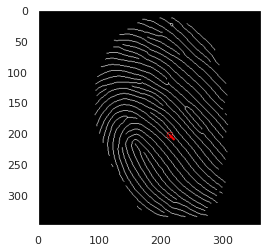

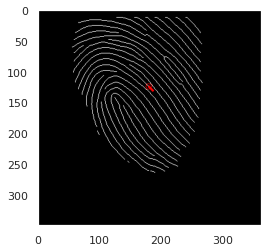

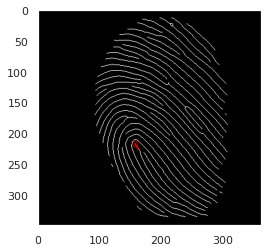

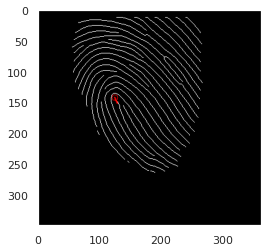

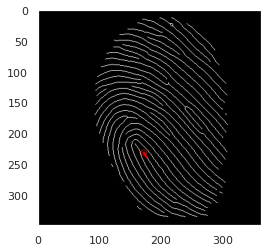

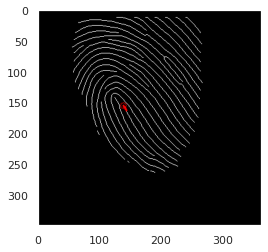

In [330]:
# Test algorithm (jiang strategy)
full_matches = True
center_plots(True)
for (i,j) in [(0,1)]: #(0,1),(0,2),(0,3),(0,4),(0,8),(0,9),(0,10),(0,11)
  feature_vectors_i = get_local_features(i)
  feature_vectors_j = get_local_features(j)
  (similarities,matches) = get_similarities(feature_vectors_i, feature_vectors_j, full=full_matches)
  if full_matches:
    draw_minutiae_matches(sorted(matches)[0:3], i, j)
  else:
    print(sorted(matches)[0:4])
    print(sum(sorted(matches)[0:4]))

*This looks very nice, the 3 first matches are perfect. However, many images are quite hard to process such that the results aren't good all that often. For example, let's look at image 73 and 77.*

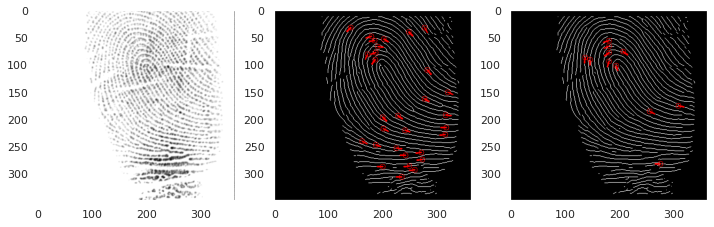

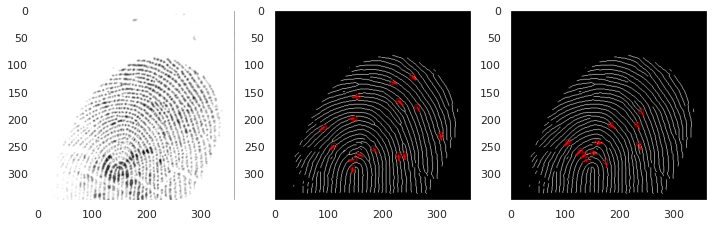

In [294]:
for i in [72,76]:
  (endings, bifurcations, skeleton) = extract_minutiae(i)   
  visualise_minutiae(images[i], orientations[i], endings, bifurcations, skeleton)

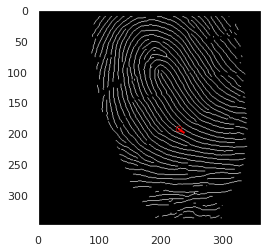

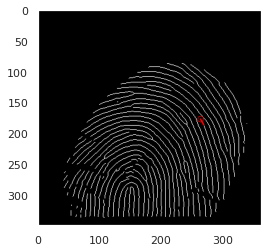

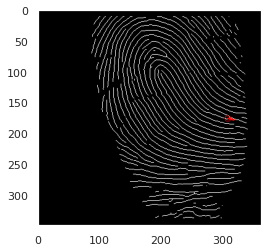

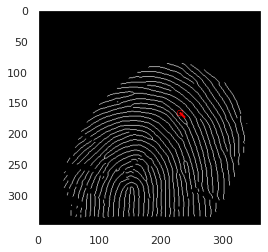

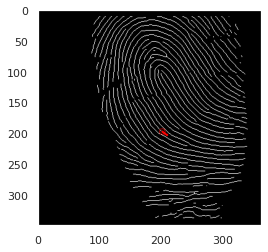

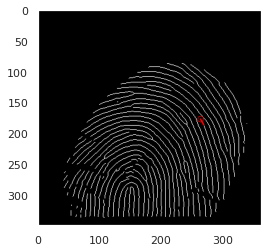

In [300]:
# Test algorithm (jiang strategy)
full_matches = True
center_plots(True)
for (i,j) in [(72,76)]: #(0,1),(0,2),(0,3),(0,4),(0,8),(0,9),(0,10),(0,11)
  feature_vectors_i = get_local_features(i)
  feature_vectors_j = get_local_features(j)
  (similarities,matches) = get_similarities(feature_vectors_i, feature_vectors_j, full=full_matches)
  sort = sorted(similarities)
  if full_matches:
    draw_minutiae_matches(sorted(matches)[0:3], i, j)
  else:
    print(sorted(matches)[0:4])
    print(sum(sorted(matches)[0:4]))

*I found a few examples like these, where there's not much overlap between the fingerprint such that the whole thing breaks.*

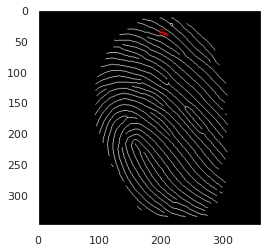

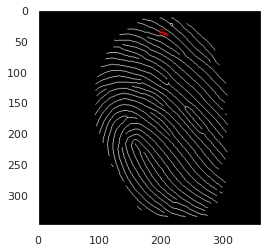

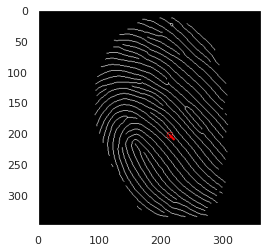

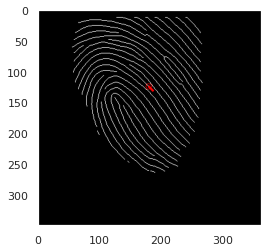

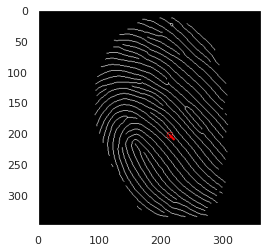

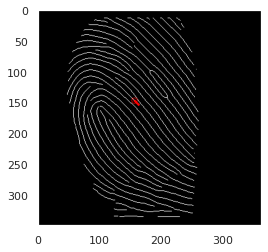

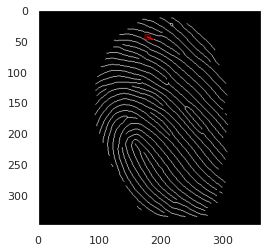

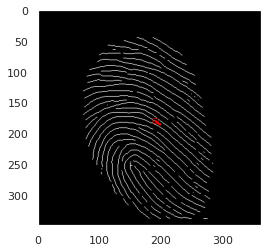

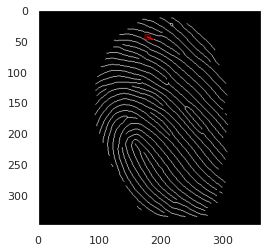

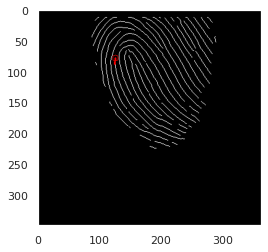

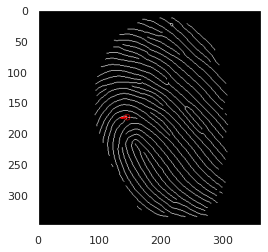

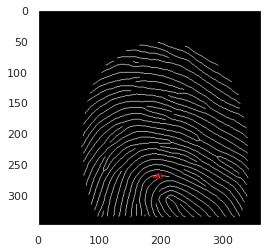

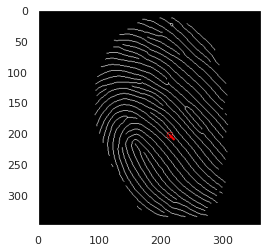

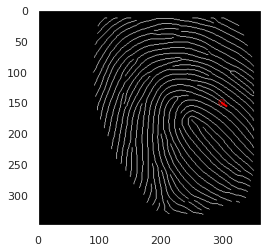

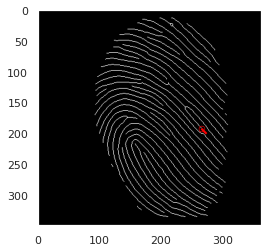

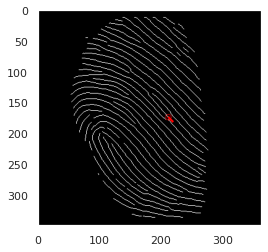

In [301]:
i = 0
for j in range(8):
  feature_vectors_i = get_local_features(i)
  feature_vectors_j = get_local_features(j)
  (similarities,matches) = get_similarities(feature_vectors_i, feature_vectors_j, full=True)
  draw_minutiae_matches(sorted(matches)[0:1], i, j)

*So overall the matching is working well at least for the first one (which is important for the global matching step), but the enhancement seems to be crucial here. It looks like anything that goes wrong can seriously screw up the results.*

In [0]:
# Calculate minutiae and save them to disk
people = 10
samples = 8
nb_images = people*samples

minutiae_file = "./fprdata/DB" + str(selected_database) + "_minutiae.p"
if os.path.isfile(minutiae_file):
  saved_pickle_file = open(minutiae_file, 'rb')
  minutiae = pickle.load(saved_pickle_file)
else:
  minutiae = [extract_minutiae(i) for i in tqdm_notebook(range(nb_images))]
  tosave_pickle_file = open(minutiae_file, 'wb')
  pickle.dump(minutiae, tosave_pickle_file)

In [0]:
def get_minutiae_score(i,j):
  (endings_i, bifurcations_i, _) = minutiae[i]
  (endings_j, bifurcations_j, _) = minutiae[j]
  features_i = get_local_features(i, endings_i, bifurcations_i)
  features_j = get_local_features(j, endings_j, bifurcations_j)
  (_,matches) = get_similarities(features_i, features_j)
  #return sum(np.asarray(matches) < 20)
  if len(matches) < 1:
    return 300
  return sum(sorted(matches)[0:1])

In [0]:
angle_difference_ = lambda a, b: (a-b) if -math.pi < (a-b) <= math.pi else (2*math.pi+a-b) if (a-b) <= -math.pi else (2*math.pi-(a-b))
angle_difference = lambda a, b: min(angle_difference_(a,b),angle_difference_(a,b-math.pi))

def get_global_features(i, endings, bifurcations, best):
  """Calculate global features (see Jiang)."""
  minutiae = endings if len(bifurcations) == 0 else np.vstack((endings,bifurcations))
  angles = [orientations[i][minutia[0]][minutia[1]] for minutia in minutiae]
  angle_best = angles[best]
  minutia_best = minutiae[best]
  arctan_difference = lambda m: angle_difference(np.arctan((m[1]-minutia_best[1])/(m[0]-minutia_best[0]+0.000001)), angle_best)
  features = []
  for m in range(len(minutiae)): # calculate match
    if m == best:
      continue
    else:
      minutia = minutiae[m]
      feature_vector = [np.sqrt((minutia_best[0]-minutia[0])**2+(minutia_best[1]-minutia[1])**2),
                        arctan_difference(minutia),
                        angle_difference(angles[m], angle_best)]
      features.append(feature_vector)
  return np.asarray(features)

def get_minutiae_global_score(i,j):
  """Calculate global score (see Jiang)."""
  (endings_i, bifurcations_i, _) = minutiae[i]
  (endings_j, bifurcations_j, _) = minutiae[j]
  features_i = get_local_features(i, endings_i, bifurcations_i)
  features_j = get_local_features(j, endings_j, bifurcations_j)
  (similarities,matches) = get_similarities(features_i, features_j, full=True)
  if len(matches) < 1:
    return 0
  (_,best_i,best_j) = sorted(matches)[0]
  global_features_i = get_global_features(i, endings_i, bifurcations_i, best_i)
  global_features_j = get_global_features(j, endings_j, bifurcations_j, best_j)
  Bg = [8,math.pi/6,math.pi/6]
  global_similarities = []
  for i_idx in range(len(global_features_i)):
    for j_idx in range(len(global_features_j)):
      f_i = global_features_i[i_idx]
      f_j = global_features_j[j_idx]
      difference = abs(f_i - f_j)
      difference[1:3] = [abs(angle_difference(a,b)) for (a,b) in zip(f_i[1:3],f_j[1:3])]
      if 3 == sum([difference[x] < Bg[x] for x in range(3)]):
        similarity = 0.5 + 0.5 * similarities[str(i_idx)+'-'+str(j_idx)]
      else:
        similarity = 0
      global_similarities.append(similarity)
  return 100 * sum(global_similarities) / max(len(features_i),len(features_j))

In [0]:
matrix, genuine, imposter = calculate_similarity_matrix(images, get_minutiae_score, lambda x: 1-x, normalize=True)
plot_distributions(genuine, imposter)

EER for MINUTIAE : ( 0.3308641975308642 )
AUC for MINUTIAE :  0.7306922398589065


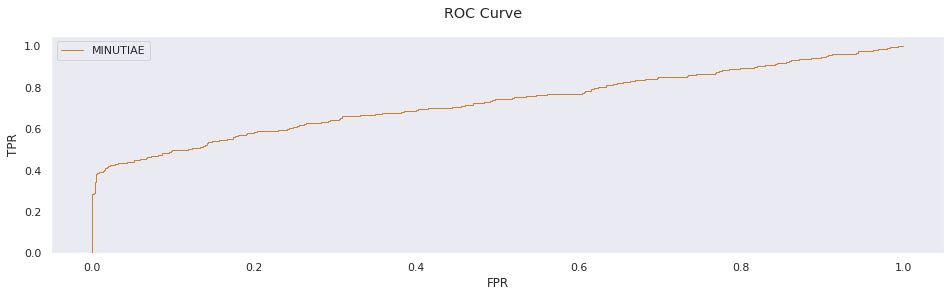

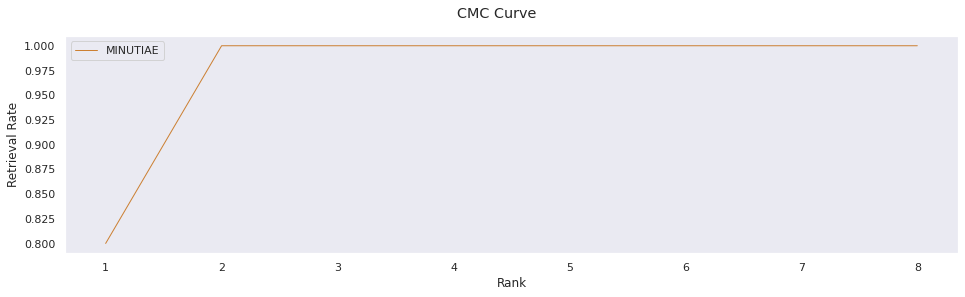

In [389]:
plot_roc(genuine, imposter, color=(0.8,0.5,0.2), label='MINUTIAE')
plot_cmc(matrix, color=(0.8,0.5,0.2), label='MINUTIAE')

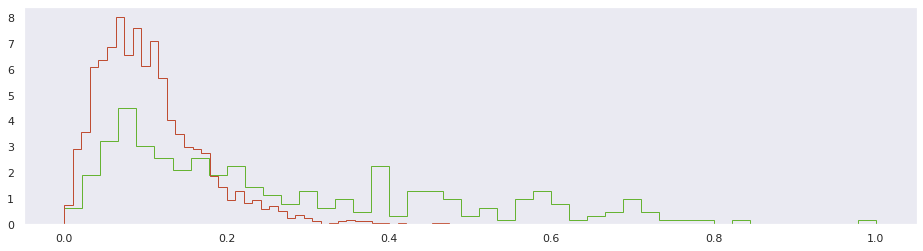

In [390]:
#test = [get_minutiae_score(0,i) for i in range(80)]
#print(test)
matrix, genuine_global, imposter_global = calculate_similarity_matrix(images, get_minutiae_global_score, lambda x: x, normalize=True)
plot_distributions(genuine_global, imposter_global)

EER for MINUTIAE_GLOBAL : ( 0.3308641975308642 )
AUC for MINUTIAE_GLOBAL :  0.7520458553791888


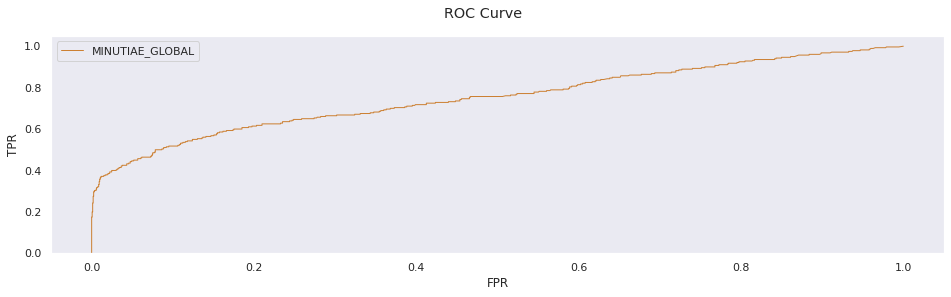

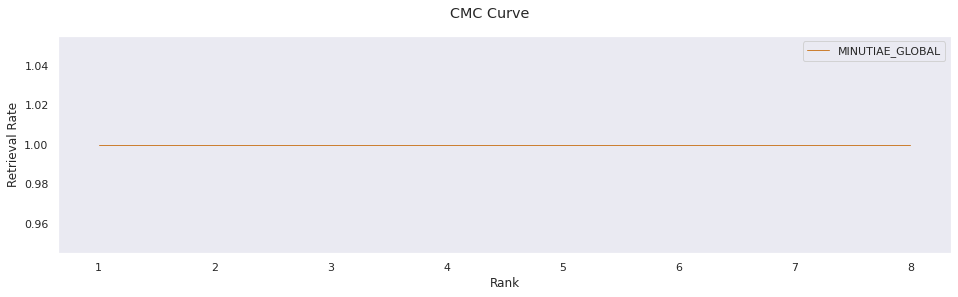

In [391]:
plot_roc(genuine_global, imposter_global, color=(0.8,0.5,0.2), label='MINUTIAE_GLOBAL')
plot_cmc(matrix, color=(0.8,0.5,0.2), label='MINUTIAE_GLOBAL')

*This is not too great. There are a few obvious reasons for this ; the enhancement part has many flaws, there are many spurious minutiae which means that a large fraction of genuine scores aren't matched well at all. And I didn't follow Jiang's approach 100% (not all features could be easily calculated from the enhancement code that was provided).* 

*Quick ensemble test to check how well the models combine ...*

NameError: ignored

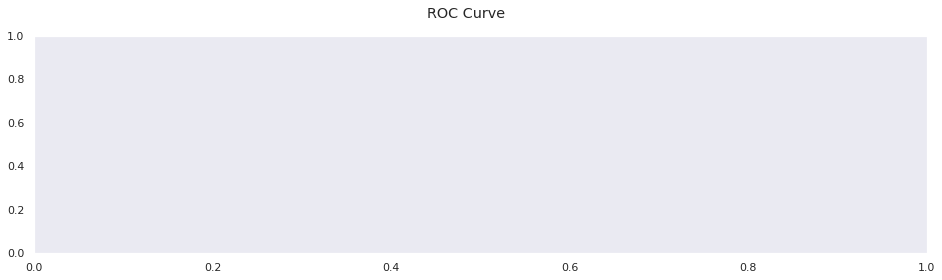

In [393]:
# Visualisation of ROC curve for ensemble
center_plots()
figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
figure.suptitle('ROC Curve')
_, genuine_scores_1, imposter_scores_1 = scores_dict['ORB_COMPOSITE']
genuine_scores_2, imposter_scores_2 = genuine_global, imposter_global
#_, genuine_scores_2, imposter_scores_2 = scores_dict['BRIEF_COMPOSITE']
genuine_scores = [(a + b)/2 for (a,b) in zip(genuine_scores_1,genuine_scores_2)]
imposter_scores = [(a + b)/2 for (a,b) in zip(imposter_scores_1,imposter_scores_2)]
strategy = 'ORB_COMPOSITE+MINUTIAE_GLOBAL'
genuine_id = np.hstack((np.ones(len(genuine_scores)), np.zeros(len(imposter_scores))))
scores = np.hstack((genuine_scores, imposter_scores))
use_sklearn_roc = True
if use_sklearn_roc:
  fpr, tpr, thresholds = roc_curve(genuine_id, scores)
  min_index = np.argmin(abs((1-tpr)-fpr))
  print("EER for " + strategy + " : (", fpr[min_index], ")") #, thresholds[min_index], fpr[min_index], ")")
  print("AUC for " + strategy + " : ", roc_auc_score(genuine_id, scores))
else: # here I tested my implementation and it worked with the EER being almost the same
  fpr, tpr, thresholds, eer = full_roc(genuine_id, scores)
  print("EER for " + strategy + " : (", eer, ")")
axes.plot(fpr, tpr, color='orange', lw=1, label=strategy) # np.random.rand(3,)
axes.set(xlabel='FPR', ylabel='TPR', ylim=[0.0,1.05])
axes.legend()
plt.show()

*An experiment can also be done with the Poincaré index.*